# HOMEWORK 2

#### Submitted By: Bhavish Kumar

#### Date: 13th October 2020

### In this homework, we compare the performance of Plain Backpropagation, BPTT, LSTM & GRU networks on a time-series forecasting problem. 
#### We will be using daily stock prices of Tesla from October 10th 2016 to October 9th 2020 (4 years of daily stock prices)

In [2]:
from __future__ import print_function
import pandas as pd
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
##from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

### Reading the Dataset into a pandas dataframe
##### The dataset contains 7 attributes in total, but we are only interested in "Adj Close", which is the closing price of Tesla's stock on the corresponding day. This is a time series dataset which shows the variation of Tesla's daily stock over time

In [4]:
df = pd.read_csv("TSLA daily closing stock.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-10-10,40.270000,40.827999,39.931999,40.189999,40.189999,16581500
1,2016-10-11,40.369999,40.439999,39.661999,40.020000,40.020000,11642000
2,2016-10-12,40.189999,40.776001,40.084000,40.301998,40.301998,9853500
3,2016-10-13,40.099998,40.180000,39.410000,40.048000,40.048000,12473000
4,2016-10-14,40.132000,40.285999,39.259998,39.301998,39.301998,21349500


##### Dropping the unnecessary columns which we are not interested in

In [5]:
df = df.drop(columns=['Date', 'Open','High','Low','Close','Volume'])
df.head()

,Adj Close
0,40.189999
1,40.020000
2,40.301998
3,40.048000
4,39.301998


#### 0 Missing values in the data

In [6]:
df.isna().sum()

Adj Close    0
dtype: int64

##### By looking at the trend of Tesla Stock Prices, we can observe that the stock prices have shot up exponentially in the last 200 days

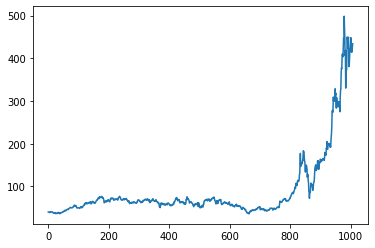

In [7]:
plt.plot(df["Adj Close"])

# Data PreProcessing

### 1. Splitting the data into Train and Test

In [8]:
len(df)

1008

##### Using the first 830 data points for Training and the last 178 data points for Testing

In [9]:
train_df = df.iloc[:830,]
test_df = df.iloc[825:,]

In [10]:
print(train_df)
print(test_df)

      Adj Close
0     40.189999
1     40.020000
2     40.301998
3     40.048000
4     39.301998
..          ...
825  113.912003
826  114.440002
827  112.963997
828  111.603996
829  113.379997

[830 rows x 1 columns]
       Adj Close
825   113.912003
826   114.440002
827   112.963997
828   111.603996
829   113.379997
...          ...
1003  425.679993
1004  413.980011
1005  425.299988
1006  425.920013
1007  434.000000

[183 rows x 1 columns]


### 2. Normalize the data

#### Using Min Max scaler to scale down all the stock values between 0 and 1 scale so as to simplify the learning process which might otherwise be very difficult with a wide range of values

##### Fitting the scaler on train data, i.e. taking the min & max values from train data and applying the same transformation on to test data

In [11]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_df)
train_df = scaler.transform(train_df)
test_df = scaler.transform(test_df)
#dfTest[['A', 'B']] = scaler.fit_transform(dfTest[['A', 'B']])

### 3. Creating X train, Y train and X_test, Y_test datasets by using previous "n" days stock price values as input to predict the stock price on day (n+1)

In [13]:
def data_prep(data_arr, input_seq_len):
    x_arr = []
    y_arr = []
    for i in range(len(data_arr)-input_seq_len):
        x_arr.append(data_arr[i:i+input_seq_len])
        y_arr.append(data_arr[i+input_seq_len])
    return np.array(x_arr), np.array(y_arr)

#### Using previous 5 days stock prices as input to predict the stock price on 6th day

In [14]:
x_train, y_train = data_prep(train_df,5)
x_test, y_test = data_prep(test_df, 5)

In [15]:
print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

825
825
178
178


### 4. Creating a Tensor Object using the DataLoader function and specifying the batch size to perform mini-batch gradient descent.
#### The algorithm will update weights after each batch.
##### Here the train_loader dataset has the predictor variables and the target variable in it. Setting Shuffle = False to maintain the sequence of Time Series

In [16]:
train_target = torch.tensor(y_train.astype(np.float32))
train = torch.tensor(x_train.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = math.ceil(len(train)/10), shuffle = False)

In [17]:
train.shape

torch.Size([825, 5, 1])

#### Doing the same on test data, but without batches. We will be calculating test_mse as a whole on the entire test dataset

In [18]:
test_target = torch.tensor(y_test.astype(np.float32))
test = torch.tensor(x_test.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(test),shuffle = False)

In [19]:
test.shape

torch.Size([178, 5, 1])

# A. Forecasting using Plain Backpropagation

### In this we build a Feed Forward Neural Network with 1 hidden layer & train the model using plain backpropagation. We will implement this using PyTorch

#### ** Detailed Explanation of ANN implementation using PyTorch **
We inherit from nn.Module and then use super().init() method to get a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from nn.Module.
The module automatically creates the weight and bias tensors as soon as we call the nn.Linear() function. We'll use these weights and bias in the forward method. The nn.Linear() function thus creates a linear transformation with the given number of inputs and outputs. The 1st parameter is the number of inputs to the layer (equal to number of attributes in data, for 1st hidden layer) and the 2nd parameter is the number of outputs from the layer (basically equal to the number of nodes in a given layer)
The forward method takes in the data/tensor 'x' and passes through layers created in the init method and produces the required output after applying the required activation functions.

In [20]:
class ann(nn.Module):    ## We are inheriting from nn.Module
    def __init__(self, ):
        super().__init__()
        self.hidden_layer1 = nn.Linear(train.shape[1], 2*train.shape[1])  ## 1st hidden layer with 'd' inputs & '2d' outputs
        self.oput_layer = nn.Linear(2*train.shape[1],1) ## output layer with '2d' inputs from hidden layer and 1 output
        
        self.sigmoid = nn.Sigmoid()  ## Define Sigmoid Activation function
        
    def forward(self, x):
        # Computes the outputs / predictions
        out = F.sigmoid(self.hidden_layer1(x))  ## Compute output of 1st hidden layer after applying the Sigmoid function
        output = self.oput_layer(out)   ## compute output of output layer
        return output

#### Writing a function which can be invoked to calculate Test MSE on the entire test dataset after every weight update using the model

In [21]:
def test_mse(model):
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs,targets in test_loader:
            inputs = inputs.view(inputs.size(0), inputs.size(1))
            output = model(inputs)
            loss = criterion(output, targets)
    return loss.item()

#### Training the model

In [22]:
model = ann()  ### Initiate the ANN class object named model

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 1000
train_MSE_aft_weight_upd = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    for inputs,targets in train_loader:    
           # Training pass
        inputs = inputs.view(inputs.size(0), inputs.size(1)) ### Changing shape of input to have batch size as 1st param & seqlen(no of lags) as 2nd 
        output = model(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd.append(loss.item())
        test_MSE_aft_weight_upd.append(test_mse(model))

C:\Users\bhavi\AppData\Local\Continuum\anaconda3\lib\site-packages\torch\nn\functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


#### We can observe that the Plain Backpropagation model is converging after around 1000 epochs and 10,000 weight updates
###### **NOTE: The Training MSE is much lower than Test MSE because the test data values are of a much larger range due to an exponential rise in Tesla Stock prices in the latest few days which is being used for Testing**

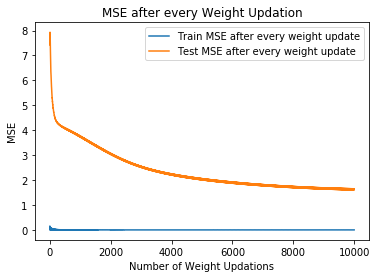

In [23]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train)/math.ceil(len(train)/10))*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd)
ax1.plot(weight_updates, test_MSE_aft_weight_upd)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

### The final Test MSE obtained using a fully trained model using Plain BackPropagation is as shown below

In [24]:
test_mse_plain_backprop = test_mse(model)
test_mse_plain_backprop

1.6235524415969849

### Calculating the Computational Effort (Number of Weight Updates) required to obtain the desirable Test MSE of <= 1.95 for PLAIN BACKPROPAGATION
##### As shown below, the Plain Backpropagation algorithm requires 926 Epochs & 9,262 weight updates to attain a desirable MSE of <= 1.95

In [26]:
plain_bp_model_comp_effort = ann()  ### Initiate the ANN class object named plain_bp_model_comp_effort

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(plain_bp_model_comp_effort.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 1000

### Training the dataset.
for e in range(1,epochs+1):
    batch_no = 0
    breaking_inner = 0
    for inputs,targets in train_loader:   
        batch_no = batch_no + 1
        # Training pass
        inputs = inputs.view(inputs.size(0), inputs.size(1))
        output = plain_bp_model_comp_effort(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        if test_mse(plain_bp_model_comp_effort) <= 1.95:
            breaking_inner = 1
            break
    if breaking_inner == 1:
        break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes

### Number of weight updates that have happened so far = product of number of batches & epochs iterated through + batch no of current epoch
No_weight_updates_plain_bp = (e * 10) + batch_no ### Since there are 10 batches in total
print("Number of Epochs elapsed = ",e,"Number of batches elapsed in current epoch = ", batch_no)
print("Total Number of Weight Updates/Computational Effort = ",No_weight_updates_plain_bp)

Number of Epochs elapsed =  926 Number of batches elapsed in current epoch =  2
Total Number of Weight Updates/Computational Effort =  9262


### Plotting Actual Stock Prices and Forecasted/Predicted Stock Prices over time

In [27]:
### OBTAINING PREDICTED STOCK PRICE VALUES
predicted_oput_plain_bp = []
with torch.no_grad():
    for inputs,targets in test_loader:
        inputs = inputs.view(inputs.size(0), inputs.size(1))
        output = model(inputs)   ### Here 'model' is the fully trained model using plain backpropagation
        predicted_oput_plain_bp.append(output)

##### Obtaining a Flat list for both Predicted Values and Actual Values

In [28]:
predicted_oput_plain_bp_lst = []
for i in range(len(y_test)):
    predicted_oput_plain_bp_lst.append(predicted_oput_plain_bp[0][i][0].tolist())

In [29]:
flat_list_ytest = [item for sublist in y_test.tolist() for item in sublist]

##### From the below time series plot we can observe that Plain BackPropagation with 5 previous stock prices as input is not able to produce very good forecast estimates, as we can see that after 100th day, the actual prices are shooting up largely but the forecasted values are not following the same trend

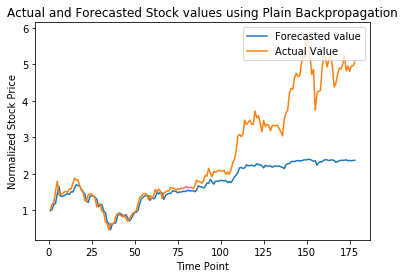

In [247]:
### The number of weight updates = number of batches x number of epochs
time_point = [el for el in range(1,179)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, predicted_oput_plain_bp_lst)
ax1.plot(time_point, flat_list_ytest)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Stock values using Plain Backpropagation')
plt.xlabel('Time Point')
plt.ylabel('Normalized Stock Price')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

# B. Forecasting using Backpropagation through Time (Recurrent Neural Network)
#### Implementing RNN with Backpropagation through time
##### ** Explaining the PyTorch Implementation of RNN **
The init method takes the input size which is the number of features, the number of RNN nodes (hidden_dim), number of RNN layers as parameters. We then define the RNN layer with input size as 1 since we have only feature for our univariate problem, we then specify the hidden_size as 10 creating 10 nodes for the RNN and then create 1 RNN layer. The 'tanh' activation function is applied on the RNN layer. This RNN layer is followed by a Linear layer which takes in 10 inputs coming from the 10 RNN nodes and produces 1 output.
Then in the forward method, which is where the forward pass takes place, we first initialize a tensor of zeroes for the hidden state of the RNN layer. The hidden state tensor data has the dimensions of number of layers, batch size and number of nodes. The tanh activation function is applied on the sum of dot products of hidden state, weights and input, weights. This output has the dimensions of batch_size, sequence_length & number of nodes. Hence we apply the slicer out[:,-1,:] to pick the last output from sequence and so the RNN layer only produces output of dimensions (batch_size, number of nodes). This sliced 10 dimensional output is paased to the linear output layer to produce 1 single output per row of a batch. The BPTT algorithm requires 1 hidden state for every node of a layer. In next section of LSTM we will have to use 2 hidden states as a LSTM cell contains two hidden states.

In [189]:
class RNN_Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers,seq_len):
        super(RNN_Model, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = input_size, hidden_size = hidden_dim,num_layers = n_layers,
                          batch_first=True, nonlinearity='tanh')   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    
    #def reset_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    #    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, _ = self.rnn(x, hidden)
        
        out_final = self.fc(out[:,-1,:])
        
        return out_final
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

#### Function to calculate Test MSE on the whole test dataset when invoked

In [190]:
def test_mse_rnn(model):
    criterion = nn.MSELoss()
    with torch.no_grad():
        for inputs,targets in test_loader:
            output = model(inputs)
            loss = criterion(output, targets)
    return loss.item()

#### Training the model

In [250]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
model_bptt = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_bptt.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 200
train_MSE_aft_weight_upd_bptt = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd_bptt = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
   # model_bptt.reset_hidden()
    for inputs,targets in train_loader:    
           # Training pass
        output = model_bptt(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_bptt.append(loss.item())
        test_MSE_aft_weight_upd_bptt.append(test_mse_rnn(model_bptt))

In [251]:
test_MSE_aft_weight_upd_bptt[-1]

1.5761833190917969

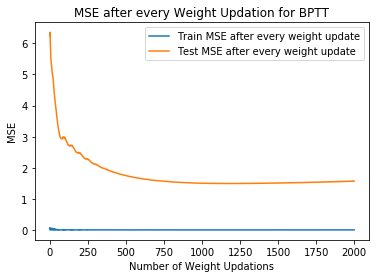

In [252]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train)/math.ceil(len(train)/10))*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_bptt)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_bptt)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation for BPTT')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

### The final Test MSE obtained using a fully trained BPTT model is as shown below

In [253]:
test_mse_bptt = test_mse_rnn(model_bptt)
test_mse_bptt

1.5761833190917969

### The Computational Effort (Number of Weight Updates) required to obtain the desirable Test MSE of <= 1.95 for BACKPROPAGATION Through Time

In [256]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
bptt_model_comp_effort = RNN_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named bptt_model_comp_effort
criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(bptt_model_comp_effort.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 1000

### Training the dataset.
for e in range(1,epochs+1):
    batch_no = 0
    breaking_inner = 0
    for inputs,targets in train_loader:   
        batch_no = batch_no + 1
        # Training pass
        output = bptt_model_comp_effort(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Obtaining the outputs for every row of the batch using the model built in ann class 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        if test_mse_rnn(bptt_model_comp_effort) <= 1.95:
            breaking_inner = 1
            break
    if breaking_inner == 1:
        break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes
    
### Number of weight updates that have happened so far = product of number of batches & epochs iterated through + batch no of current epoch
if e == 1000:
    No_weight_updates_bptt = (e * 10)
else:
    No_weight_updates_bptt = (e * 10) + batch_no ### Since there are 10 batches in total
print("Number of Epochs elapsed = ",e,"Number of batches elapsed in current epoch = ", batch_no)
print("Total Number of Weight Updates/Computational Effort = ",No_weight_updates_bptt)

Number of Epochs elapsed =  261 Number of batches elapsed in current epoch =  2
Total Number of Weight Updates/Computational Effort =  2612


### Plotting Actual Stock Prices and Forecasted/Predicted Stock Prices over time

In [208]:
### OBTAINING PREDICTED STOCK PRICE VALUES
predicted_oput_bptt = []
with torch.no_grad():
    for inputs,targets in test_loader:
        output = model_bptt(inputs)   ### Here 'model' is the fully trained model using plain backpropagation
        predicted_oput_bptt.append(output)

In [209]:
predicted_oput_bptt_lst = []
for i in range(len(y_test)):
    predicted_oput_bptt_lst.append(predicted_oput_bptt[0][i][0].tolist())

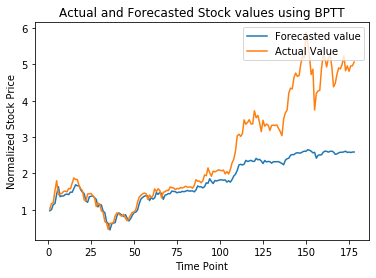

In [210]:
### The number of weight updates = number of batches x number of epochs
time_point = [el for el in range(1,179)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, predicted_oput_bptt_lst)
ax1.plot(time_point, flat_list_ytest)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Stock values using BPTT')
plt.xlabel('Time Point')
plt.ylabel('Normalized Stock Price')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

# C. Forecasting using LSTM network

##### The working and implementation is same as the above BPTT model with the only difference being the use of an LSTM layer which requires the initialization of 2 hidden states (ht & ct) as initialized below.

In [179]:
class LSTM_Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers,seq_len):
        super(LSTM_Model, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        

        #Defining the layers
        # RNN Layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_dim,num_layers = n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    
    #def reset_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    #    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_dim),
    #                  torch.zeros(self.n_layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        #out, _ = self.lstm(x.view(len(x),self.seq_len,self.input_size), hidden)
        out, _ = self.lstm(x, hidden)
        #out_final = self.fc(out.view(self.seq_len,len(x),self.hidden_dim)[-1])
        out_final = self.fc(out[:,-1,:])
        return out_final
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

#### Training the model

In [170]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
model_lstm = LSTM_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_lstm.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 300
train_MSE_aft_weight_upd_lstm = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd_lstm = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    #model_lstm.reset_hidden()
    for inputs,targets in train_loader:    
           # Training pass
        output = model_lstm(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_lstm.append(loss.item())
        test_MSE_aft_weight_upd_lstm.append(test_mse_rnn(model_lstm))

In [171]:
test_MSE_aft_weight_upd_lstm[-1]

1.2593770027160645

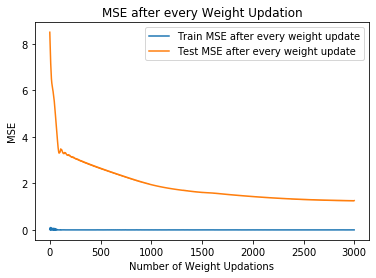

In [172]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train)/math.ceil(len(train)/10))*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_lstm)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_lstm)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

### The final Test MSE obtained using a fully trained LSTM model is as shown below

In [231]:
test_mse_lstm = test_mse_rnn(model_lstm)
test_mse_lstm

1.2593770027160645

### The Computational Effort (Number of Weight Updates) required to obtain the desirable Test MSE of <= 1.95 for LSTM

In [180]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
model_lstm_comp_effort = LSTM_Model(input_size,hidden_dim,n_layers,seq_len)

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_lstm_comp_effort.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 1000

### Training the dataset.
for e in range(1,epochs+1):
    batch_no = 0
    breaking_inner = 0
    for inputs,targets in train_loader:   
        batch_no = batch_no + 1
        # Training pass
        output = model_lstm_comp_effort(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Obtaining the outputs for every row of the batch using the model built in ann class 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        if test_mse_rnn(model_lstm_comp_effort) <= 1.95:
            breaking_inner = 1
            break
    if breaking_inner == 1:
        break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes
    
### Number of weight updates that have happened so far = product of number of batches & epochs iterated through + batch no of current epoch
if e == 1000:
    No_weight_updates_lstm = (e * 10)
else:
    No_weight_updates_lstm = (e * 10) + batch_no ### Since there are 10 batches in total
print("Number of Epochs elapsed = ",e,"Number of batches elapsed in current epoch = ", batch_no)
print("Total Number of Weight Updates/Computational Effort = ",No_weight_updates_lstm)

Number of Epochs elapsed =  206 Number of batches elapsed in current epoch =  3
Total Number of Weight Updates/Computational Effort =  2063


### Plotting Actual Stock Prices and Forecasted/Predicted Stock Prices over time

In [175]:
### OBTAINING PREDICTED STOCK PRICE VALUES
predicted_oput_lstm = []
with torch.no_grad():
    for inputs,targets in test_loader:
        output = model_lstm(inputs)   ### Here 'model' is the fully trained model using plain backpropagation
        predicted_oput_lstm.append(output)

In [176]:
predicted_oput_lstm_lst = []
for i in range(len(y_test)):
    predicted_oput_lstm_lst.append(predicted_oput_lstm[0][i][0].tolist())

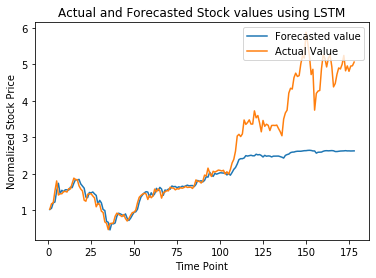

In [257]:
### The number of weight updates = number of batches x number of epochs
time_point = [el for el in range(1,179)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, predicted_oput_lstm_lst)
ax1.plot(time_point, flat_list_ytest)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Stock values using LSTM')
plt.xlabel('Time Point')
plt.ylabel('Normalized Stock Price')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

# D. Forecasting using GRU network
###### Using a GRU layer and one hidden state with dimensions of number of layers, batch size and number of nodes (hidden dim)

In [214]:
class GRU_Model(nn.Module):
    def __init__(self, input_size, hidden_dim, n_layers,seq_len):
        super(GRU_Model, self).__init__()

        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.seq_len = seq_len
        

        #Defining the layers
        # GRU Layer
        self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_dim,num_layers = n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 1)
    
    
    #def reset_hidden(self):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
    #    self.hidden = (torch.zeros(self.n_layers, self.seq_len, self.hidden_dim),
    #                  torch.zeros(self.n_layers, self.seq_len, self.hidden_dim))
    
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        #out, _ = self.lstm(x.view(len(x),self.seq_len,self.input_size), hidden)
        out, _ = self.gru(x, hidden)
        #out_final = self.fc(out.view(self.seq_len,len(x),self.hidden_dim)[-1])
        out_final = self.fc(out[:,-1,:])
        return out_final
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim))
        return hidden

#### Training the model

In [226]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
model_gru = GRU_Model(input_size,hidden_dim,n_layers,seq_len)  ### Initiate the RNN class object named model_bptt

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_gru.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 200
train_MSE_aft_weight_upd_gru = []  ### List to store MSE after every weight update i.e. after every batch
test_MSE_aft_weight_upd_gru = [] ### List to store the Test MSE after every weight update, i.e. after every batch

### Training the dataset.
for e in range(epochs):
    #model_lstm.reset_hidden()
    for inputs,targets in train_loader:    
           # Training pass
        output = model_gru(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Backpropogating based on the loss 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        train_MSE_aft_weight_upd_gru.append(loss.item())
        test_MSE_aft_weight_upd_gru.append(test_mse_rnn(model_gru))

In [227]:
test_MSE_aft_weight_upd_gru[-1]

1.3572828769683838

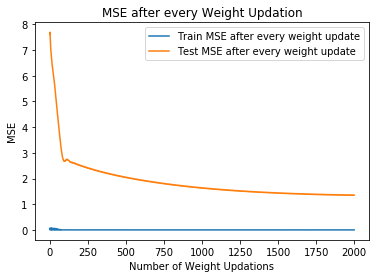

In [228]:
### The number of weight updates = number of batches x number of epochs
weight_updates = [el for el in range(math.ceil(len(train)/math.ceil(len(train)/10))*epochs)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(weight_updates, train_MSE_aft_weight_upd_gru)
ax1.plot(weight_updates, test_MSE_aft_weight_upd_gru)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Train MSE after every weight update', 'Test MSE after every weight update'], loc='upper right')
plt.title('MSE after every Weight Updation')
plt.xlabel('Number of Weight Updations')
plt.ylabel('MSE')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

### The final Test MSE obtained using a fully trained GRU model is as shown below

In [230]:
test_mse_gru = test_mse_rnn(model_gru)
test_mse_gru

1.3572828769683838

### The Computational Effort (Number of Weight Updates) required to obtain the desirable Test MSE of <= 1.95 for GRU

In [233]:
input_size = 1
hidden_dim = 10
n_layers = 1
seq_len = 5
model_gru_comp_effort = GRU_Model(input_size,hidden_dim,n_layers,seq_len)

criterion = nn.MSELoss()  ### Define the loss function which is Mean Squared Error

optimizer = optim.Adam(model_gru_comp_effort.parameters(), lr=0.005) # Optimizers require the model parameters to optimize and a learning rate

epochs = 1000

### Training the dataset.
for e in range(1,epochs+1):
    batch_no = 0
    breaking_inner = 0
    for inputs,targets in train_loader:   
        batch_no = batch_no + 1
        # Training pass
        output = model_gru_comp_effort(inputs)   ### Obtaining the outputs for every row of the batch using the model built in ann class
        loss = criterion(output, targets) ### Calculating the Loss for every row of the batch using the obtained output & target
        loss.backward()   ### Obtaining the outputs for every row of the batch using the model built in ann class 
        optimizer.step()  ### Updating the weights based on the gradient using the optimizer.step() function
        optimizer.zero_grad() ### Erasing the gradient values after every weight update
        if test_mse_rnn(model_gru_comp_effort) <= 1.95:
            breaking_inner = 1
            break
    if breaking_inner == 1:
        break ### Break from the outer loop if we break from the inner loop also and then run for the next value of number of nodes
    
### Number of weight updates that have happened so far = product of number of batches & epochs iterated through + batch no of current epoch
if e == 1000:
    No_weight_updates_gru = (e * 10)
else:
    No_weight_updates_gru = (e * 10) + batch_no ### Since there are 10 batches in total
print("Number of Epochs elapsed = ",e,"Number of batches elapsed in current epoch = ", batch_no)
print("Total Number of Weight Updates/Computational Effort = ",No_weight_updates_gru)

Number of Epochs elapsed =  89 Number of batches elapsed in current epoch =  3
Total Number of Weight Updates/Computational Effort =  893


### Plotting Actual Stock Prices and Forecasted/Predicted Stock Prices over time

In [234]:
### OBTAINING PREDICTED STOCK PRICE VALUES
predicted_oput_gru = []
with torch.no_grad():
    for inputs,targets in test_loader:
        output = model_gru(inputs)   ### Here 'model' is the fully trained model using plain backpropagation
        predicted_oput_gru.append(output)

In [235]:
predicted_oput_gru_lst = []
for i in range(len(y_test)):
    predicted_oput_gru_lst.append(predicted_oput_gru[0][i][0].tolist())

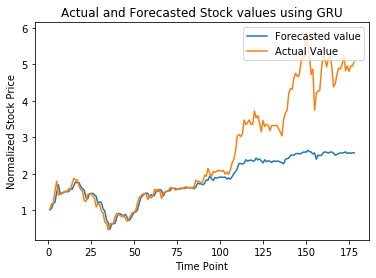

In [236]:
### The number of weight updates = number of batches x number of epochs
time_point = [el for el in range(1,179)]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(time_point, predicted_oput_gru_lst)
ax1.plot(time_point, flat_list_ytest)
#ax1.set_xticks(weight_updates)
#ax1.set_xticklabels(weight_updates)
plt.legend(['Forecasted value', 'Actual Value'], loc='upper right')
plt.title('Actual and Forecasted Stock values using GRU')
plt.xlabel('Time Point')
plt.ylabel('Normalized Stock Price')
plt.show()


#plt.plot(weight_updates,MSE)
#plt.show()

# Plotting Line Graphs to comapre Best MSE & Computational Effort

In [258]:
Final_MSEs = [test_mse_plain_backprop,test_mse_bptt,test_mse_lstm,test_mse_gru]
Computational_Efforts = [No_weight_updates_plain_bp,No_weight_updates_bptt,No_weight_updates_lstm,No_weight_updates_gru]
Networks = ["PLAIN BACKPROPAGATION","BPTT","LSTM","GRU"]

###### From the below figure which shows the Best Test MSE attained by each network, we can observe that LSTM & GRU networks yield the best performance with the LSTM network model producing the lowest Test MSE of 1.25, as obtained in the above implemnetation section. This is followed by the GRU model with a Test MSE of 1.35. As expected, the performance of Plain Backpropagation & BPTT are poorer than that of LSTM & GRU which have the capability to remember the historical data (Stability) and also to learn new inputs (Plasticity). This Stability & Plasticity capabilities can be the reason for their enhanced performance.

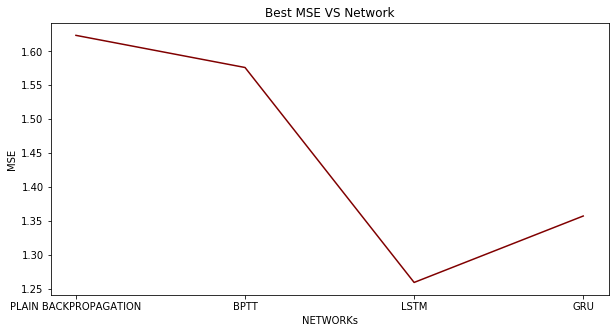

In [259]:
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.plot(Networks, Final_MSEs, color ='maroon') 
  
plt.xlabel("NETWORKs") 
plt.ylabel("MSE") 
plt.title("Best MSE VS Network") 
plt.show() 

##### From the below figure which shows the Computational Effort (Number of Weight Updates) required by each of the models to attained  a desirable Test MSE of <= 1.95. The Plain Backpropagation model requires the highest computational effort of 9,262 weight updates, whereas the GRU model requires the lowest computational effort of 893 weight updates only. This result is also in line with our expectations, as we know that LSTM & GRU models converge very quickly with minimal effort because of their Elasticity, Plastcity capabilities.

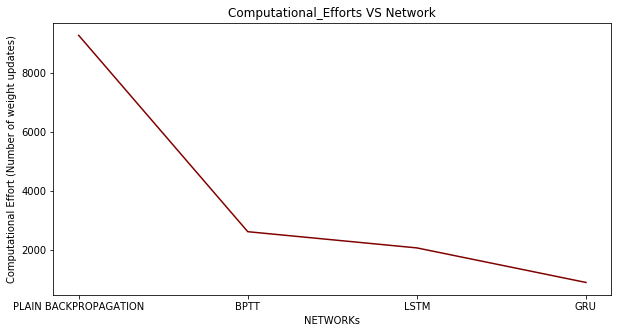

In [261]:
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.plot(Networks, Computational_Efforts, color ='maroon') 
  
plt.xlabel("NETWORKs") 
plt.ylabel("Computational Effort (Number of weight updates)") 
plt.title("Computational_Efforts VS Network") 
plt.show() 

### CONCLUSION

Based on the above 2 results of Best MSE & Computational Effort, we can conclude that it is wise to choose either LSTM or GRU network models for this Time Series Forecasting problem, as they require minimum computational effort and also produce the lowest Test MSE. Now, between LSTM & GRU there is an Effort versus Results dilemma, where LSTM is producing better MSE results and GRU on the other hand is taking lower computational effort. Hence, any one of the 2 can be chosen depending on the requirement of the user.

## END of HOMEWORK 2